In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"] =12

In [2]:
volcanodata = pd.read_excel("MI_compilation_XH2O.xlsx", sheet_name="XH2O_calculated_filtered")

SiO2_min = 30
SiO2_max = 57

vdatafilt = volcanodata[(volcanodata['SiO2'].between(SiO2_min, SiO2_max)) &
                                   (volcanodata['FluidMass_grams_VESIcal'] != 0)]  # Filtering SiO2 <= 57

vdatafilt.loc[:, 'Raman/Homog'] = vdatafilt['Raman/Homog'].fillna('')




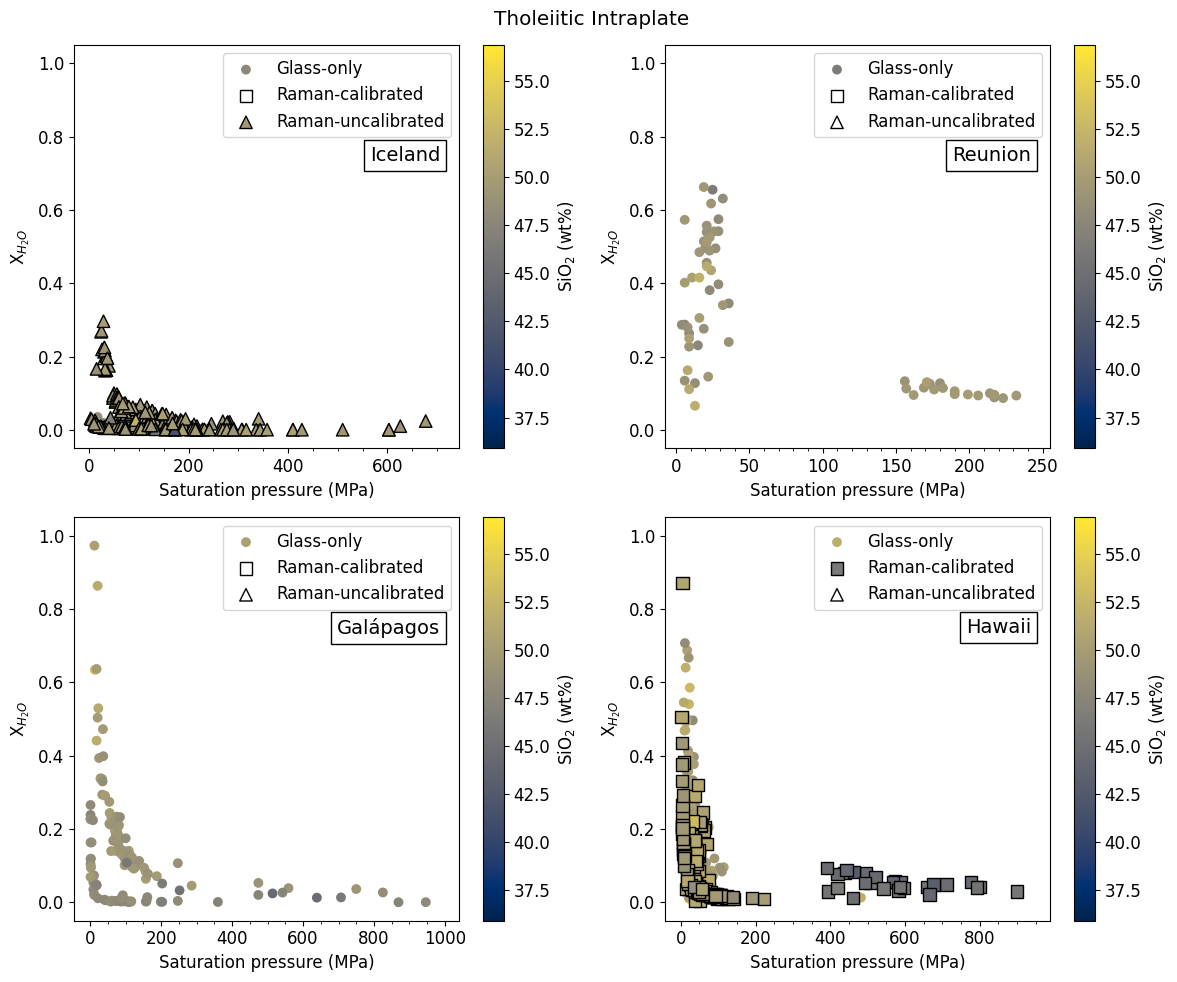

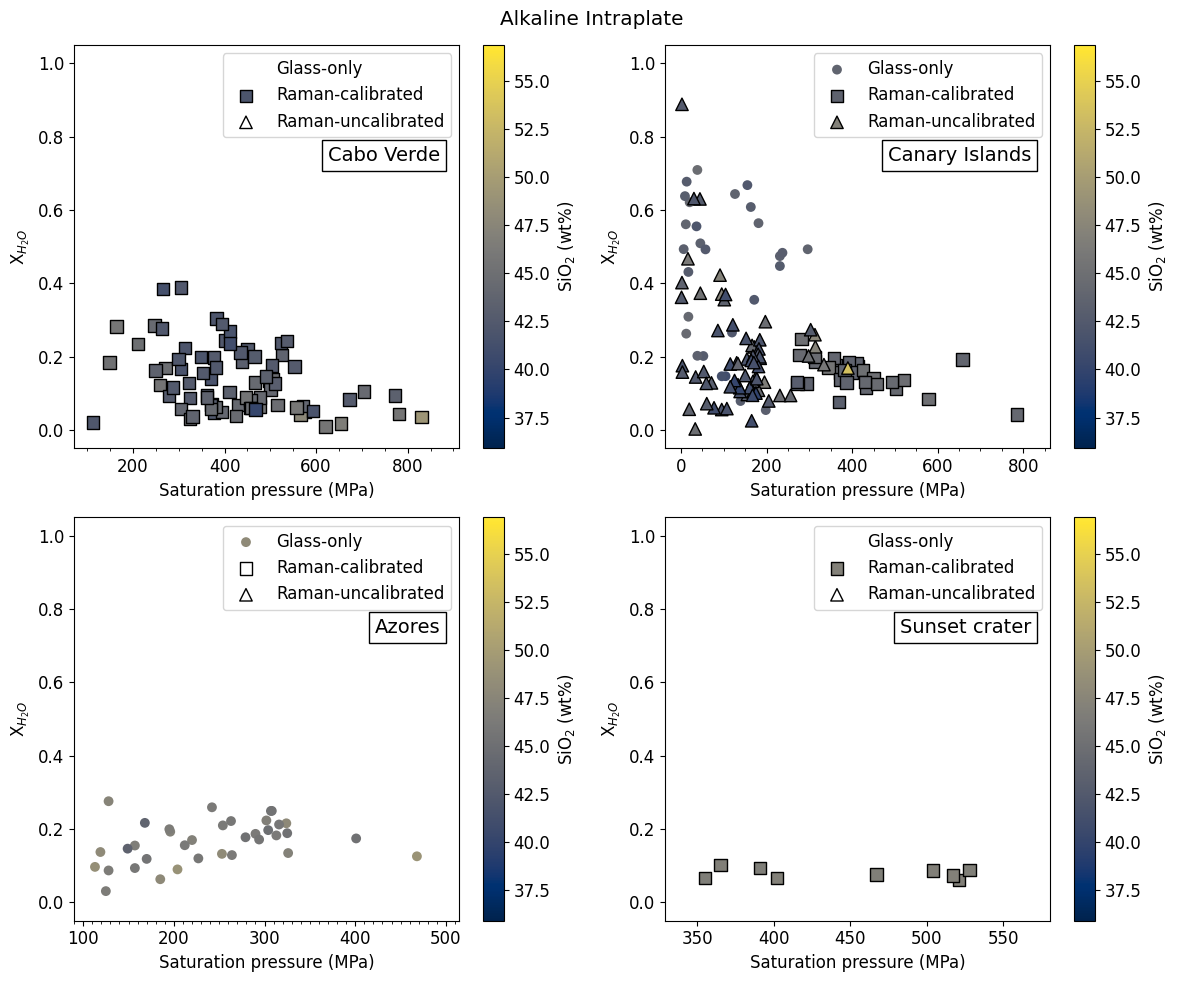

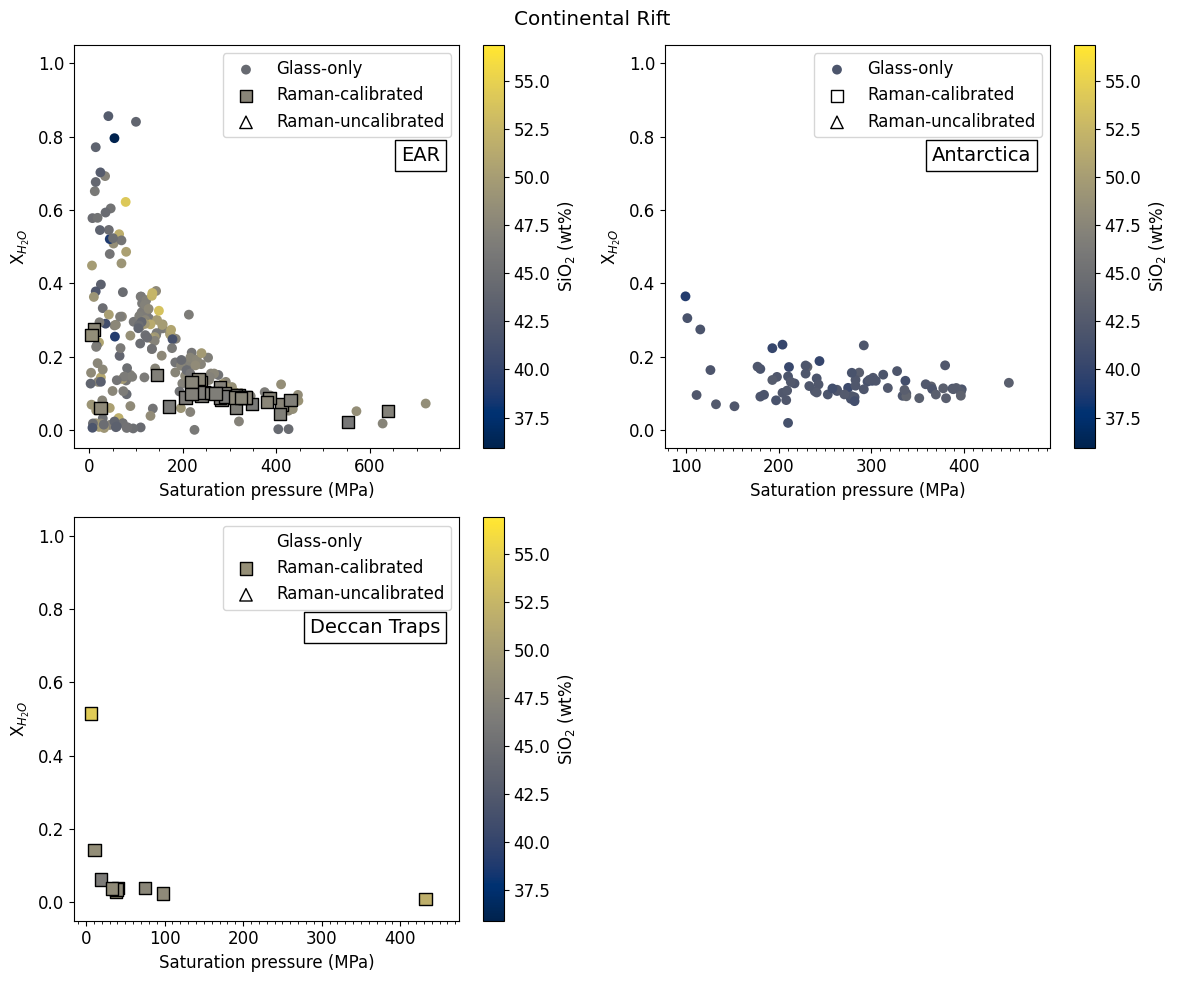

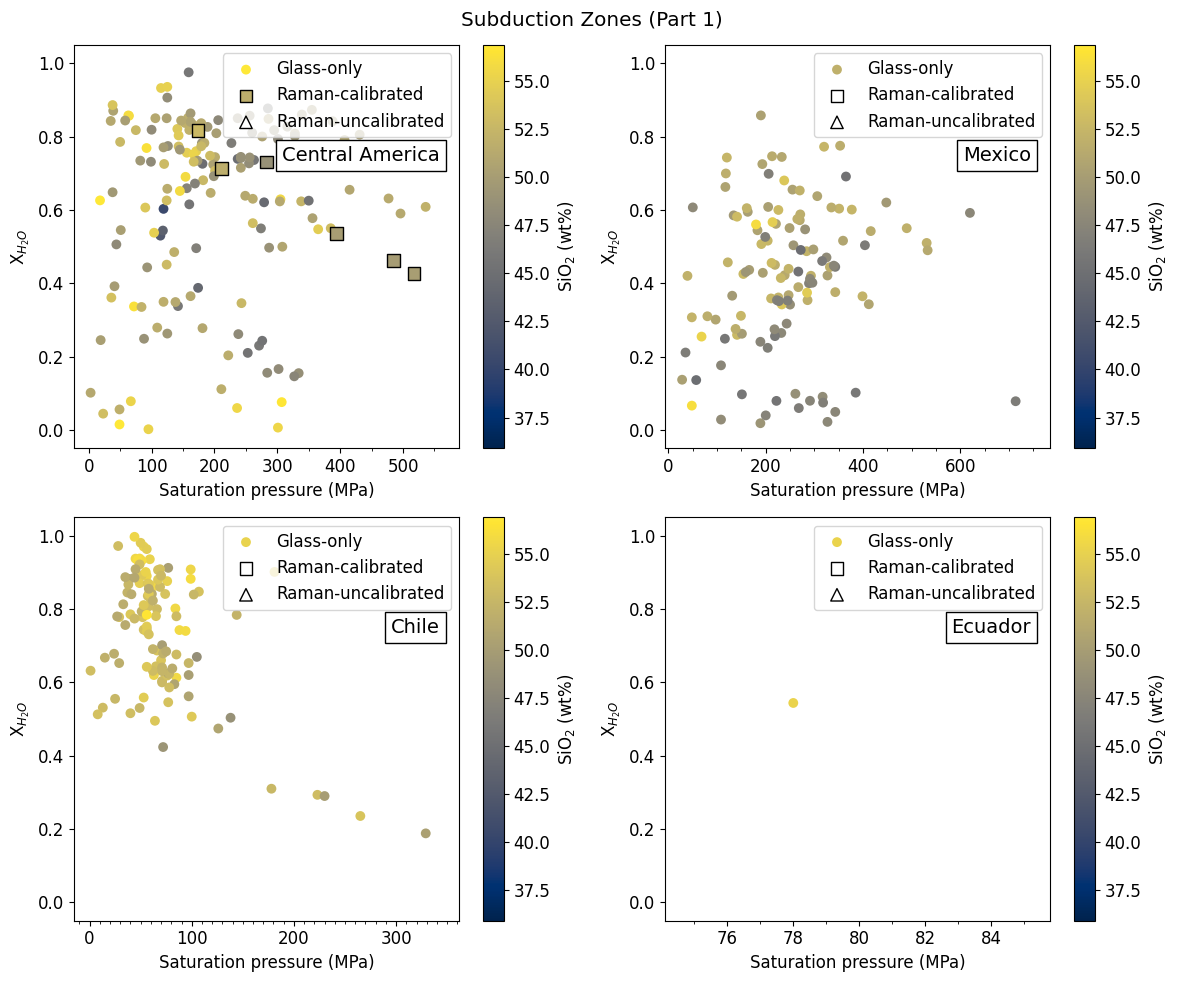

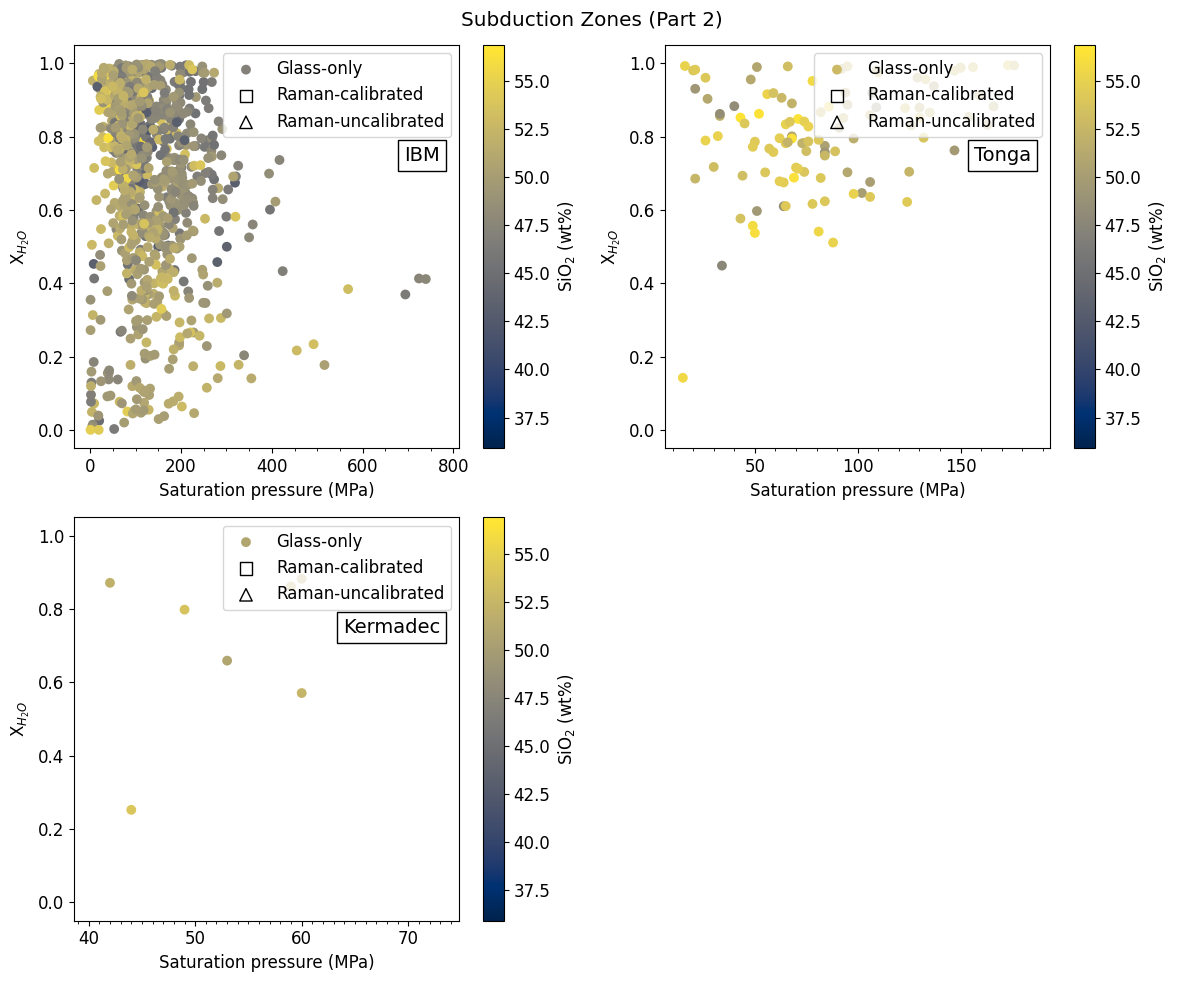

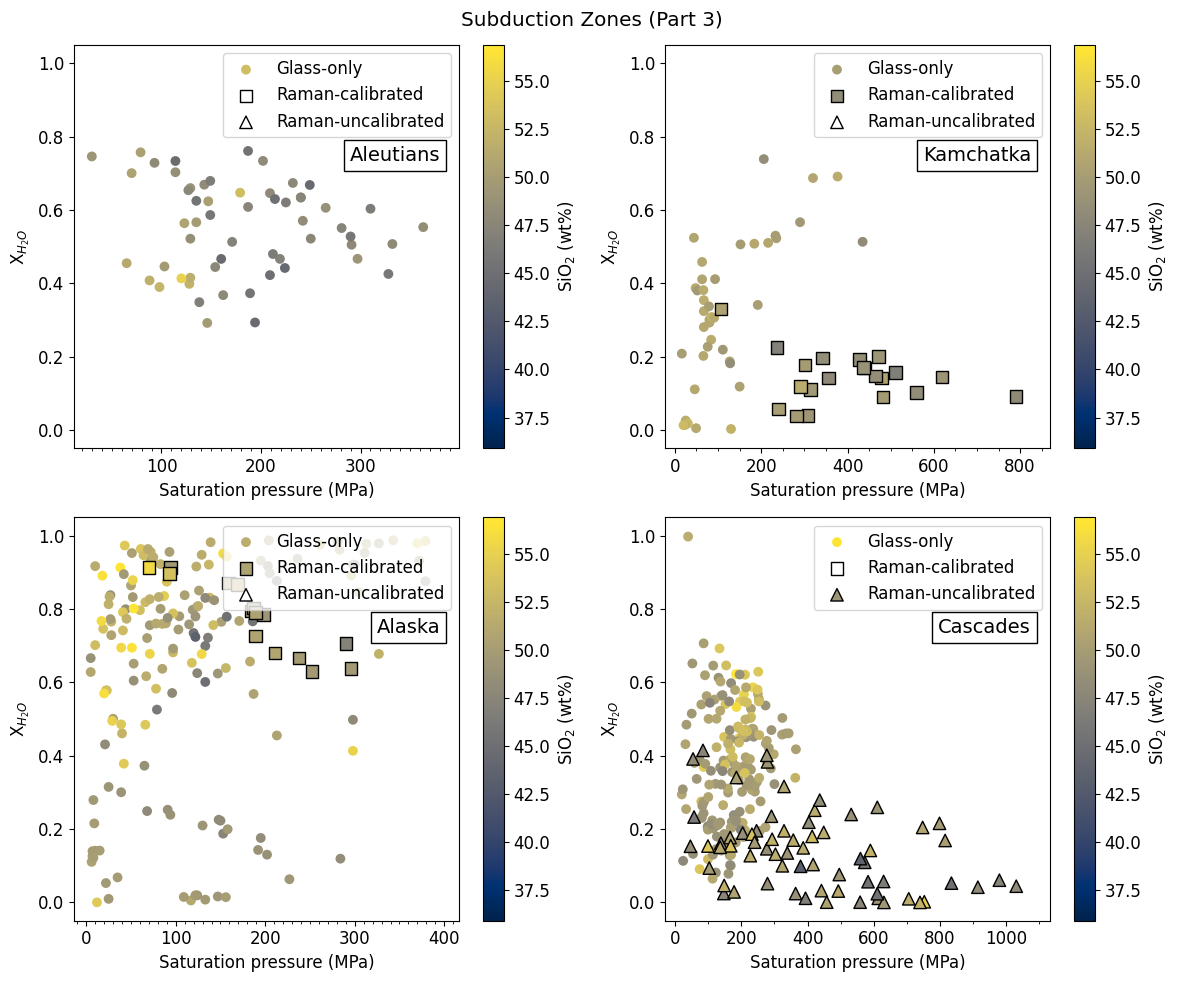

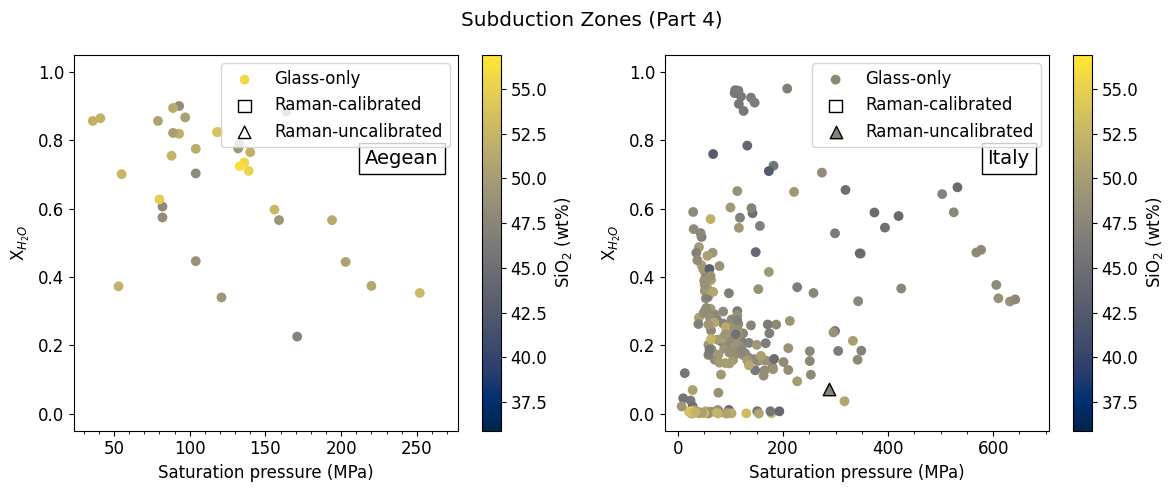

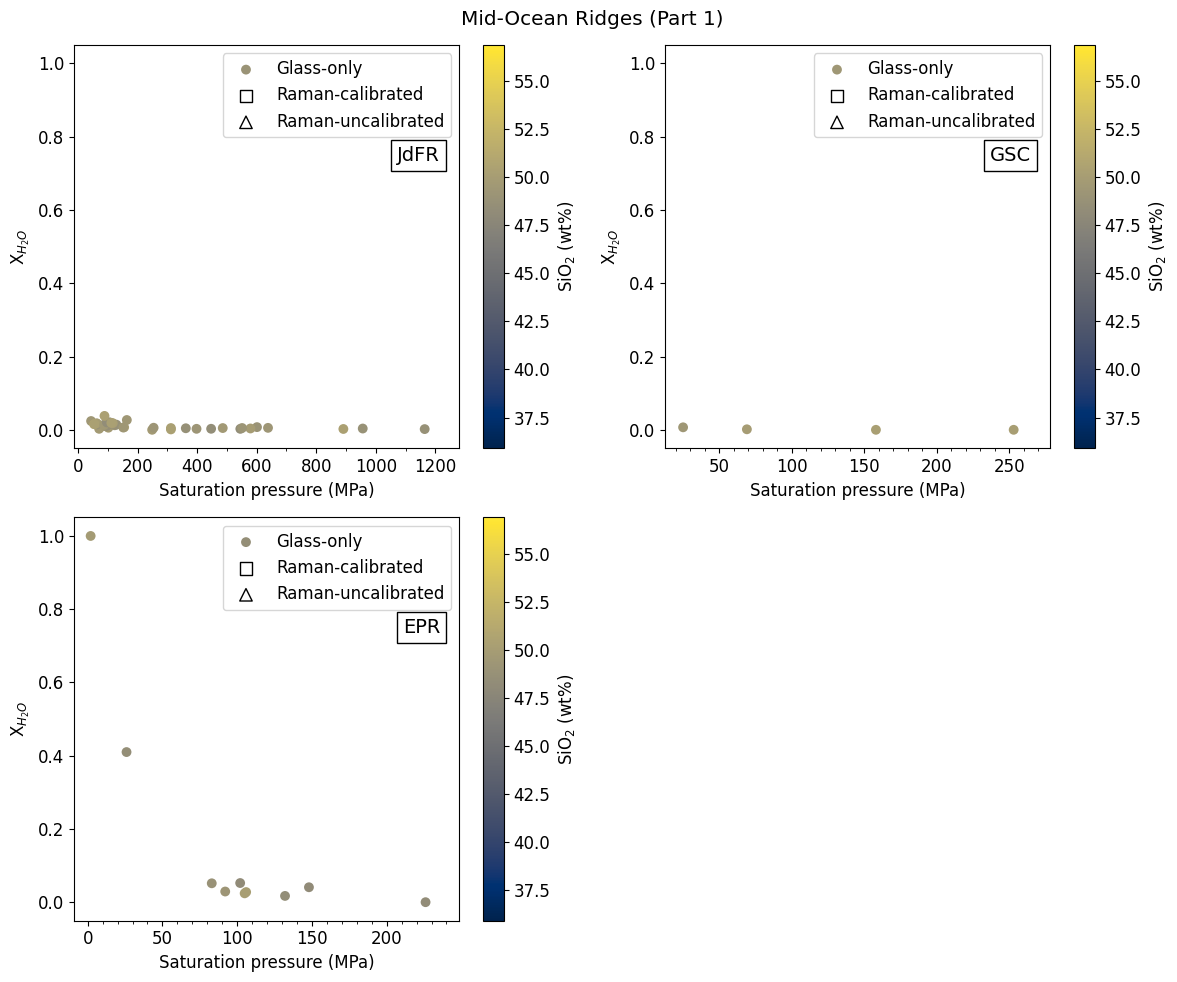

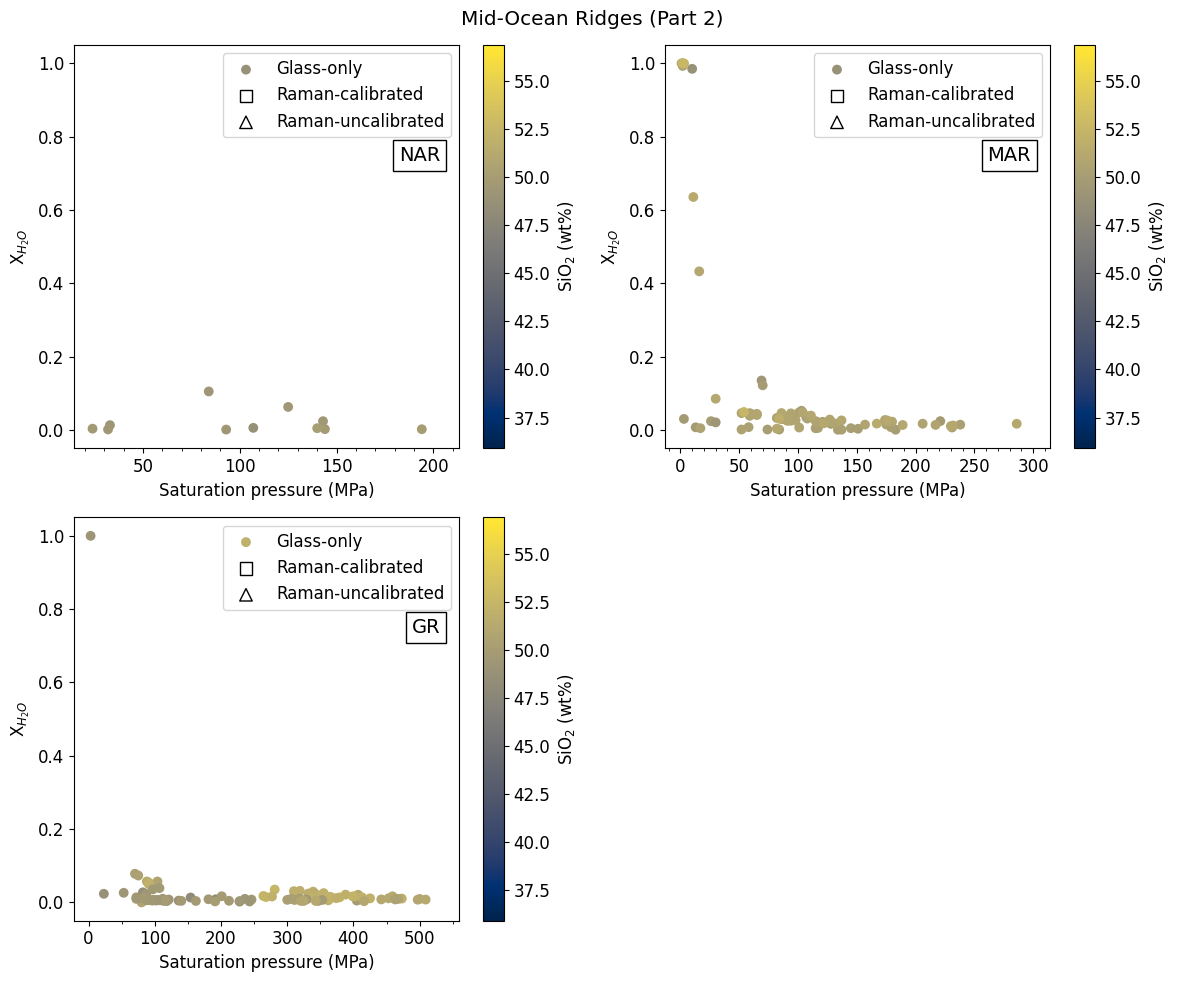

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

siO2_min_all = vdatafilt['SiO2'].min()
siO2_max_all = vdatafilt['SiO2'].max()

# Convert saturation pressure from bars to MPa
satP_min_all = vdatafilt['SaturationP_bars_VESIcal'].min() / 10
satP_max_all = vdatafilt['SaturationP_bars_VESIcal'].max() / 10

siO2_colormap = plt.get_cmap('cividis')

x_col = 'SaturationP_bars_VESIcal'
y_col = 'XH2O_fl_VESIcal'

# Lists of 'Location type'
locations_lists = [
    ['Iceland', 'Reunion', 'Galápagos', 'Hawaii'],
    ['Cabo Verde', 'Canary Islands', 'Azores', 'Sunset crater'],
    ['EAR', 'Antarctica', 'Deccan Traps'],
    ['Central America', 'Mexico', 'Chile', 'Ecuador'],
    ['IBM', 'Tonga', 'Kermadec'],
    ['Aleutians', 'Kamchatka', 'Alaska', 'Cascades'],
    ['Aegean', 'Italy'],
    ['JdFR', 'GSC', 'EPR'],
    ['NAR', 'MAR', 'GR']
]
loctype_lists = [
    'Tholeiitic Intraplate',
    'Alkaline Intraplate',
    'Continental Rift',
    'Subduction Zones (Part 1)',
    'Subduction Zones (Part 2)',
    'Subduction Zones (Part 3)',
    'Subduction Zones (Part 4)',
    'Mid-Ocean Ridges (Part 1)',
    'Mid-Ocean Ridges (Part 2)'
]

# Determine the number of rows needed for subplot arrangement for each location list
num_cols = 2
num_rows = [((len(locations) + num_cols - 1) // num_cols) for locations in locations_lists]

# Create subplots for each location list
for locations, num_row, loc_type in zip(locations_lists, num_rows, loctype_lists):
    fig, axs = plt.subplots(num_row, num_cols, figsize=(6*num_cols, 5*num_row))  # 5 columns

    # Flatten the axs array if there's only one row
    if num_row == 1:
        axs = axs.reshape(1, -1)

    for i, location in enumerate(locations):
        row_index = i // num_cols
        col_index = i % num_cols

        glassonly = vdatafilt[(vdatafilt['Location'] == location) & ~(vdatafilt['Raman/Homog'].str.contains('Raman|Homog'))]
        ramancal = vdatafilt[(vdatafilt['Location'] == location) & (vdatafilt['Raman/Homog'].str.contains('Raman-cal'))]
        ramanuncal = vdatafilt[(vdatafilt['Location'] == location) & (vdatafilt['Raman/Homog'].str.contains('Raman-uncal'))]

        scatter_glassonly = axs[row_index, col_index].scatter(glassonly[x_col] / 10, glassonly[y_col],
                                                              c=glassonly['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                              edgecolor='none', s=50, label='Glass-only', marker='o')

        scatter_ramancal = axs[row_index, col_index].scatter(ramancal[x_col] / 10, ramancal[y_col],
                                                              c=ramancal['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                              edgecolor='k', s=80, label='Raman-calibrated', marker='s')

        scatter_ramanuncal = axs[row_index, col_index].scatter(ramanuncal[x_col] / 10, ramanuncal[y_col],
                                                                c=ramanuncal['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                                edgecolor='k', s=80, label='Raman-uncalibrated', marker='^')

        max_x=max(vdatafilt[(vdatafilt['Location'] == location)][x_col])/10
        min_x=min(vdatafilt[(vdatafilt['Location'] == location)][x_col])/10
        # Add annotation
        axs[row_index, col_index].annotate(location, xy=(0.95, 0.75), xycoords='axes fraction', fontsize=14,
                                           ha='right', va='top', bbox=bbox,transform=axs[row_index,col_index].transAxes)

        axs[row_index, col_index].set_xlabel('Saturation pressure (MPa)')  # Update x-axis label
        axs[row_index, col_index].set_ylabel('X$_{H_2O}$')

        axs[row_index, col_index].legend(loc='upper right')
        axs[row_index, col_index].set_ylim([-0.05, 1.05])
        axs[row_index, col_index].set_xlim([min_x-0.05*max_x, max_x+0.1*max_x])  # Update x-axis limit


        if max_x < 100:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(1))
        elif 100 <= max_x < 500:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(10))
        elif 500 <= max_x < 1000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(50))
        elif 1000 <= max_x < 5000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(100))
        elif max_x>=5000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(500))


        # Add color bar
        cbar_glassonly = fig.colorbar(scatter_glassonly, ax=axs[row_index, col_index])
        cbar_glassonly.set_label('SiO$_2$ (wt%)')
    
    fig.suptitle(loc_type)
    # Hide any extra empty subplots
    for i in range(len(locations), num_row * num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig('FigS_Loop_'+str(loc_type)+'.pdf')
